In [1]:
! git clone "https://github.com/KanghwaSisters/DQN_minesweeper.git"

Cloning into 'DQN_minesweeper'...
remote: Enumerating objects: 9824, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 9824 (delta 8), reused 0 (delta 0), pack-reused 9809 (from 1)
Receiving objects: 100% (9824/9824), 69.07 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (2658/2658), done.


In [2]:
import os
os.chdir('/content/DQN_minesweeper/codes/Environment')

In [3]:
! python reward5.py
from reward5 import *

In [4]:
env = MinesweeperEnv(map_size=(5,5),
                     n_mines=5,
                     rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':0.3, 'no_progress' : -1},
                     dones={'win':True, 'lose':True, 'progress':False, 'guess':False, 'no_progress' : False},
                     dim2=False)

In [6]:
import pandas as pd
import numpy as np
import copy
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [99]:
import pandas as pd
import numpy as np
import copy
from collections import deque
from IPython.display import display
import pickle
import random

# level dict
level = {'easy' : {'map_size':(9,9), 'n_mines' : 10},
         'medium' : {'map_size':(16,16), 'n_mines':40},
         'expert' : {'map_size':(16,30), 'n_mines':99}}


class MinesweeperEnv:
    '''
    This env has 5 rewards : win, lose, progress, guess, and no_progress.
    '''
    def __init__(self,
                 map_size,
                 n_mines,
                 rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':0.3, 'no_progress' : -1},
                 dones={'win':True, 'lose':True, 'progress':False, 'guess':False, 'no_progress' : False},
                 dim2=True):

        # 지뢰찾기 맵에 대한 기본 정보
        self.map_size = map_size
        self.nrows, self.ncols = map_size
        self.total_tiles = self.nrows*self.ncols # n_tiles에서 변경함
        self.total_mines = n_mines # action_space
        self.dim2 = dim2

        # state type에 따라 달라지는 channel의 수
        self.n_channel = 1 if self.dim2 else 11

        # 학습을 위한 정보
        self.rewards = rewards
        self.dones = dones

        # 지뢰찾기 판 생성
        self.board = self.make_init_board()

        # state 생성
        self.state = self.create_state(self.board)

        # 상황 판단을 위한 파라미터
        self.unrevealed = -1.0 / 8.0

    def seed_mines(self):
        actual_board = np.zeros(shape=self.total_tiles, dtype='object')

        # 지뢰 생성
        mine_indices = np.random.choice(self.total_tiles, self.total_mines, replace=False)
        actual_board[mine_indices] = "M"

        # actual board map_size로 복구
        actual_board = actual_board.reshape(self.map_size)

        return actual_board

    def complete_actual_board(self, actual_board):
        padded_actual_board = np.pad(actual_board, pad_width=1, mode='constant', constant_values=0)
        completed_actual_board = actual_board

        for x in range(0, self.nrows):
            for y in range(0, self.ncols):
                if actual_board[x, y] == "M":
                    continue
                else:
                    kernel = padded_actual_board[x:x+3, y:y+3] # padded_actual_board에서의 x,y값은 기존의 +1이라서
                    # kernel[1,1] = 0 _ 논리 상으로는 있는게 맞지만 없어도 문제는 안된다. 중앙이 지뢰일 경우가 없기 때문에
                    completed_actual_board[x, y] = np.sum(kernel == 'M')

        return completed_actual_board

    def make_init_board(self):
        board = np.ones(shape=(2,self.nrows, self.ncols),dtype='object') # (revealed_or_not, game_board)
        actual_board = self.seed_mines()
        actual_board = self.complete_actual_board(actual_board)
        board[1] = actual_board

        return board

    def create_3dim_state(state, map_size):
        new_state = np.zeros((11, *map_size))

        for i in range(-2,9):
            new_state[i] = (state == i).astype(float)

        return new_state

    def create_state(self, board):
        revealed_mask = board[0]
        actual_board = copy.deepcopy(board[1])

        # Convert 'M' mines to numerical representation
        actual_board[actual_board == "M"] = -2

        masked_state = np.ma.masked_array(actual_board, revealed_mask)
        masked_state = masked_state.filled(-1)  # -1 represents unrevealed.

        if self.dim2:
            scaled_state = masked_state / 8
            scaled_state = scaled_state.astype(np.float16)
        else:
            masked_state = masked_state.astype(np.float16)
            scaled_state = MinesweeperEnv.create_3dim_state(masked_state, self.map_size)

        return scaled_state

    def get_coord(self, action_idx):
        # 선택한 action을 더 가시적이게 나타내기 위해
        x, y = divmod(action_idx, self.ncols)

        return (x, y)

    def click(self, action_idx):
        # click한 타일을 reveal
        clicked_coord = self.get_coord(action_idx)
        self.board[0][clicked_coord] = 0
        value = self.board[1][clicked_coord]

        unrevealed_mask = self.board[0] # revealed : 0, unrevealed : 1
        actual_board = self.board[1].reshape(1,self.total_tiles)

        # 첫 번째로 선택한 타일은 지뢰가 아니어야 함.
        if (value == 'M') & (np.sum(unrevealed_mask == 0) == 1):
            safe_tile_indices = np.nonzero(actual_board!='M')[1]
            another_move_idx = np.random.choice(safe_tile_indices)
            another_move_coord = self.get_coord(another_move_idx)

            # 지뢰를 이전한다.
            self.board[1][another_move_coord] = 'M'
            self.board[1][clicked_coord] = 0 # 초기화 용

            # 갱신한 내용을 바탕으로 다시 판을 계산한다.
            self.board[1] = self.complete_actual_board(self.board[1])
            value = self.board[1][clicked_coord]

        # 선택한 타일이 0이라면 주변의 타일이 깨진다.
        if value == 0.0:
            self.reveal_neighbors(clicked_coord)

    def reveal_neighbors(self, coord):
        queue = deque([coord])
        seen = set([coord])
        while queue:
            current_coord = queue.popleft()
            x,y = current_coord

            if self.board[1][x,y] == 0:
                for col in range(max(0,y-1), min(y+2, self.ncols)):
                    for row in range(max(0,x-1), min(x+2,self.nrows)):
                        if (row, col) not in seen:
                            seen.add((row, col))
                            queue.append((row, col))

                            self.board[0][row, col] = 0 # 아마 필요없을 것

    def reset(self):
        # 지뢰찾기 판 생성
        self.board = self.make_init_board()
        # state 생성
        self.state = self.create_state(self.board)

    def step(self, action_idx):
        done = False
        coord = self.get_coord(action_idx)

        current_mask = copy.deepcopy(self.board[0])

        # action에 따라 행동을 수행
        self.click(action_idx)

        # update state
        next_state = self.create_state(self.board)
        self.state = next_state

        # About Reward
        if self.board[1][coord] == 'M':
            reward = self.rewards['lose']
            done = self.dones['lose']

        elif np.sum(self.board[0] == 1) == self.total_mines:
            reward = self.rewards['win']
            done = self.dones['win']

        elif current_mask[coord] == 0: # 이미 깐 타일을 눌렀을 때
            reward = self.rewards['no_progress']
            done = self.dones['no_progress']

        else:
            padded_unrevealed = np.pad(current_mask, pad_width=1, mode='constant', constant_values=1)

            if np.sum(padded_unrevealed[coord[0]:coord[0]+3, coord[1]:coord[1]+3] == 1) == 9: # 아무 정보 없이 누른 타일
                reward = self.rewards['guess']
                done = self.dones['guess']

            else:
                reward = self.rewards['progress']
                done = self.dones['progress']

        return self.state, reward, done

    def restore_to_2dim(self, state):
        constant = np.array(list(range(9)) + [-2, -1])
        state = copy.deepcopy(state)

        restored_state = state * constant[:, None, None]
        restored_state = np.sum(restored_state, axis=0).astype(int)
        return restored_state

    def render(self, state):
        # 원래 값으로 복구한 뒤 시각화한다.
        if self.dim2:
            state = (state * 8.0).astype(np.int8)
        else:
            state = self.restore_to_2dim(state)

        state = state.astype(object)
        state[state == -1] = '.'
        state[state == -2] = 'M'
        state_df = pd.DataFrame(state.reshape((self.map_size)))

        display(state_df.style.applymap(self.color_state))
        print(" ")

    def color_state(self, value):
        if value == '.':
            color = 'white'
        elif value == 0:
            color = 'slategrey'
        elif value == 1:
            color = 'blue'
        elif value == 2:
            color = 'green'
        elif value == 3:
            color = 'red'
        elif value == 4:
            color = 'midnightblue'
        elif value == 5:
            color = 'brown'
        elif value == 6:
            color = 'aquamarine'
        elif value == 7:
            color = 'black'
        elif value == 8:
            color = 'silver'
        else:
            color = 'magenta'

        return f'color: {color}'

class LimitedMinesweeperEnv(MinesweeperEnv):
    def __init__(self, map_size, n_mines, total_boards=None, train=True):
        super().__init__(map_size, n_mines)

        self.train = train

        if total_boards is None:
            with open("/content/drive/MyDrive/Minesweeper [RL]/dataset/easy1000boards.pkl","rb") as f:
                self.total_boards = pickle.load(f)
        else:
            self.total_boards = total_boards

        self.n_boards = len(self.total_boards)

        if train:
            self.board = self.total_boards[0]
        else:
            self.board_iteration = iter(self.total_boards)
            self.board = next(self.board_iteration)

    def reset(self):
        self.n_clicks = 0
        self.n_progress = 0

        if self.train:
            self.board = random.choice(self.total_boards)
            self.board[0] = np.ones(shape=self.map_size) # board가 수정되기 때문에 초기화해줘야 한다.
        else:
            try:
                self.board = next(self.board_iteration)
            except StopIteration:
                # Optionally: Reinitialize the iterator if you want to cycle through the boards
                self.board_iteration = iter(self.total_boards)
                self.board = next(self.board_iteration)

        self.state = self.create_state(self.board)

In [100]:
# 학습 관련 파라미터
MEM_SIZE_MAX = 50000
MEM_SIZE_MIN = 1000
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DISCOUNT = 0.1
EPSILON = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
UPDATE_TARGET_EVERY = 5
EPISODES = 10000

# CNN 관련 파라미터
CONV_UNITS = 64
INPUT_DIMS = (1, 11, 5, 5)

In [114]:
class MinesweeperCNN(nn.Module):
    def __init__(self, input_dims, n_actions, conv_units, in_channels=11):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=conv_units, kernel_size=(3,3), padding=2)
        self.conv2 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), padding=1)

        self.flatten = nn.Flatten()

        fc_size = conv_units * (input_dims[-1]+2) * (input_dims[-2]+2)

        self.fc = nn.Linear(fc_size, n_actions)

    def forward(self, x):
        # conv area
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = self.flatten(x)
        # flatten area
        x = self.fc(x)

        return x

In [122]:
class DQN_Agent:
    def __init__(self, env):
        self.env = env  # 환경을 인자로 받아 저장
        self.input_dims = (11, 5, 5)  # 상태 차원 설정
        self.n_actions = 25  # 행동의 수 설정

        # Hyperparameters
        self.lr = LEARNING_RATE
        self.gamma = DISCOUNT
        self.epsilon = EPSILON
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY
        self.batch_size = BATCH_SIZE
        self.update_target_every = UPDATE_TARGET_EVERY

        # Initialize memory
        self.memory = deque(maxlen=MEM_SIZE_MAX)

        # Main and target networks
        self.policy_net = MinesweeperCNN(self.input_dims, self.n_actions, conv_units=CONV_UNITS).to(device)
        self.target_net = MinesweeperCNN(self.input_dims, self.n_actions, conv_units=CONV_UNITS).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        # Counter for updating target network
        self.update_counter = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, testing=False):
        if testing:
            state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
            with torch.no_grad():
                actions = self.policy_net(state_tensor)
            return torch.argmax(actions).item()

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_actions)

        state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
        with torch.no_grad():
            actions = self.policy_net(state_tensor)

        return torch.argmax(actions).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return None  # 배치가 충분하지 않을 경우 None 반환

        # Sample mini-batch from memory
        minibatch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
        actions = torch.tensor(actions).to(device)
        rewards = torch.tensor(rewards).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.bool).to(device)

        # Current Q-values
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Next Q-values using target network
        with torch.no_grad():
            max_next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones.int()) * self.gamma * max_next_q_values

        # Loss calculation
        loss = nn.MSELoss()(q_values, target_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.update_counter += 1
        if self.update_counter % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        return loss.item()  # 손실 값 반환

    def save_model(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load_model(self, path):
        self.policy_net.load_state_dict(torch.load(path))
        self.target_net.load_state_dict(self.policy_net.state_dict())


In [125]:
import torch
import numpy as np

# Hyperparameters
num_episodes = 1000  # 훈련할 에피소드 수
max_steps = 100  # 각 에피소드에서 최대 스텝 수

# 환경 초기화
env = MinesweeperEnv(map_size=(5, 5),
                     n_mines=5,
                     rewards={'win': 1, 'lose': -1, 'progress': 0.3, 'guess': 0.3, 'no_progress': -1},
                     dones={'win': True, 'lose': True, 'progress': False, 'guess': False, 'no_progress': False},
                     dim2=False)

# 에이전트 초기화
agent = DQN_Agent(env)  # 환경을 인자로 전달하여 에이전트 초기화

# 훈련 루프
all_rewards = []
all_steps = []
total_loss = 0

for episode in range(num_episodes):
    state = env.reset()  # 환경 초기화
    state = env.state  # 상태를 env에서 가져온다
    done = False
    total_reward = 0
    steps = 0

    for step in range(max_steps):
        action = agent.choose_action(state)  # 행동 선택
        next_state, reward, done = env.step(action)  # 환경에서 스텝 수행

        agent.remember(state, action, reward, next_state, done)  # 경험 기억
        state = next_state  # 다음 상태로 업데이트
        total_reward += reward  # 보상 누적
        steps += 1  # 스텝 수 증가

        loss = agent.replay()  # 경험 리플레이를 통해 네트워크 업데이트

        if done:
            break  # 에피소드 종료 시 루프 종료

    all_rewards.append(total_reward)
    all_steps.append(steps)
    if loss is not None:  # 손실이 None이 아닐 경우에만 추가
        total_loss += loss

    # 100회마다 출력
    if (episode + 1) % 100 == 0:
        average_reward = np.mean(all_rewards[-100:])  # 마지막 100 에피소드 평균 보상
        average_steps = np.mean(all_steps[-100:])  # 마지막 100 에피소드 평균 스텝 수
        success_rate = np.sum(np.array(all_rewards[-100:]) == 1) / 100 * 100  # 성공률 (보상이 1인 경우)
        average_loss = total_loss / 100 if total_loss != 0 else 0  # 마지막 100 에피소드 평균 손실
        epsilon = agent.epsilon  # 현재 ε 값

        print(f"Episode: {episode + 1}, Average Reward: {average_reward:.2f}, "
              f"Average Steps: {average_steps:.2f}, Success Rate: {success_rate:.2f}%, "
              f"Avg Loss: {average_loss:.4f}, Epsilon: {epsilon:.4f}")

        # 통계 초기화
        total_loss = 0  # 손실 초기화

print("Training completed.")

Episode: 100, Average Reward: -3.75, Average Steps: 8.26, Success Rate: 0.00%, Avg Loss: 0.0652, Epsilon: 0.0186
Episode: 200, Average Reward: -3.05, Average Steps: 8.05, Success Rate: 0.00%, Avg Loss: 0.0286, Epsilon: 0.0100
Episode: 300, Average Reward: -2.59, Average Steps: 6.80, Success Rate: 0.00%, Avg Loss: 0.0403, Epsilon: 0.0100
Episode: 400, Average Reward: -3.95, Average Steps: 9.09, Success Rate: 0.00%, Avg Loss: 0.0291, Epsilon: 0.0100
Episode: 500, Average Reward: -2.32, Average Steps: 7.77, Success Rate: 0.00%, Avg Loss: 0.0280, Epsilon: 0.0100
Episode: 600, Average Reward: -2.36, Average Steps: 7.29, Success Rate: 0.00%, Avg Loss: 0.0347, Epsilon: 0.0100
Episode: 700, Average Reward: -2.16, Average Steps: 7.14, Success Rate: 0.00%, Avg Loss: 0.0364, Epsilon: 0.0100
Episode: 800, Average Reward: -3.84, Average Steps: 9.69, Success Rate: 0.00%, Avg Loss: 0.0372, Epsilon: 0.0100
Episode: 900, Average Reward: -2.77, Average Steps: 7.83, Success Rate: 1.00%, Avg Loss: 0.0349,

<ipython-input-122-3db0c1489372>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.policy_net.load_state_dict(torch.load(path))


Average Reward: -0.40
Success Rate: 0.00%


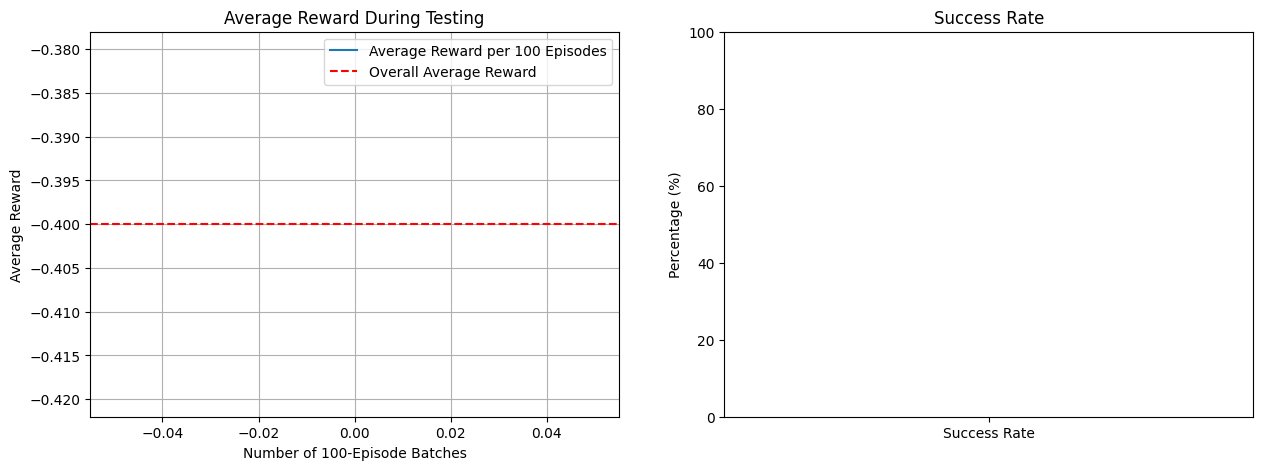

In [138]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 테스트 하이퍼파라미터
num_test_episodes = 1 # 테스트할 에피소드 수

# 환경 초기화
env = MinesweeperEnv(map_size=(5, 5),
                     n_mines=5,
                     rewards={'win': 1, 'lose': -1, 'progress': 0.3, 'guess': 0.3, 'no_progress': -1},
                     dones={'win': True, 'lose': True, 'progress': False, 'guess': False, 'no_progress': False},
                     dim2=False)

# 에이전트 초기화
agent = DQN_Agent(env)
agent.load_model('model_episode_1000.pth')  # 훈련된 모델 불러오기 (적절한 파일 이름으로 변경)

# 테스트 루프
all_rewards = []  # 각 에피소드의 보상을 저장할 리스트
all_losses = []   # 평균 손실을 저장할 리스트
success_count = 0  # 성공한 에피소드 수

for episode in range(num_test_episodes):
    state = env.reset()  # 환경 초기화
    state = env.state  # 상태를 env에서 가져온다
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state, testing=True)  # 테스트 중이므로 ε를 0으로 설정
        next_state, reward, done = env.step(action)  # 환경에서 스텝 수행

        total_reward += reward  # 보상 누적
        state = next_state  # 다음 상태로 업데이트

    all_rewards.append(total_reward)  # 총 보상 기록
    success_count += (total_reward == 1)  # 보상이 1인 경우 성공 카운트

# 성공률 계산
success_rate = (success_count / num_test_episodes) * 100  # 성공률 (%)
average_reward = np.mean(all_rewards)  # 평균 보상

# 그래프 그리기
plt.figure(figsize=(15, 5))

# 평균 보상 그래프
plt.subplot(1, 2, 1)
plt.plot(average_reward, label='Average Reward per 100 Episodes')
plt.axhline(y=average_reward, color='r', linestyle='--', label='Overall Average Reward')
plt.title('Average Reward During Testing')
plt.xlabel('Number of 100-Episode Batches')
plt.ylabel('Average Reward')
plt.legend()
plt.grid()

# 성공률 그래프
plt.subplot(1, 2, 2)
plt.bar(['Success Rate'], [success_rate], color='green')
plt.ylim(0, 100)
plt.title('Success Rate')
plt.ylabel('Percentage (%)')


print(f"Average Reward: {average_reward:.2f}")
print(f"Success Rate: {success_rate:.2f}%")


In [139]:
num_episodes = 2500
max_steps = 15  # 각 에피소드에서 최대 스텝 수

env = MinesweeperEnv(map_size=(5, 5),
                     n_mines=5,
                     rewards={'win': 1, 'lose': -1, 'progress': 0.3, 'guess': 0.3, 'no_progress': -1},
                     dones={'win': True, 'lose': True, 'progress': False, 'guess': False, 'no_progress': False},
                     dim2=False)

agent = DQN_Agent(env)

# 훈련 루프
all_rewards = []
all_steps = []
total_loss = 0

for episode in range(num_episodes):
    state = env.reset()  # 환경 초기화
    state = env.state  # 상태를 env에서 가져온다
    done = False
    total_reward = 0
    steps = 0

    for step in range(max_steps):
        action = agent.choose_action(state)  # 행동 선택
        next_state, reward, done = env.step(action)  # 환경에서 스텝 수행

        agent.remember(state, action, reward, next_state, done)  # 경험 기억
        state = next_state  # 다음 상태로 업데이트
        total_reward += reward  # 보상 누적
        steps += 1  # 스텝 수 증가

        loss = agent.replay()  # 경험 리플레이를 통해 네트워크 업데이트

        if done:
            break  # 에피소드 종료 시 루프 종료

    all_rewards.append(total_reward)
    all_steps.append(steps)
    if loss is not None:  # 손실이 None이 아닐 경우에만 추가
        total_loss += loss

    # 100회마다 출력
    if (episode + 1) % 100 == 0:
        average_reward = np.mean(all_rewards[-100:])  # 마지막 100 에피소드 평균 보상
        average_steps = np.mean(all_steps[-100:])  # 마지막 100 에피소드 평균 스텝 수
        success_rate = np.sum(np.array(all_rewards[-100:]) > 0) / 100 * 100  # 성공률
        average_loss = total_loss / 100 if total_loss != 0 else 0  # 마지막 100 에피소드 평균 손실
        epsilon = agent.epsilon  # 현재 ε 값

        print(f"Episode: {episode + 1}, Average Reward: {average_reward:.2f}, "
              f"Average Steps: {average_steps:.2f}, Success Rate: {success_rate:.2f}%, "
              f"Avg Loss: {average_loss:.4f}, Epsilon: {epsilon:.4f}")

        # 통계 초기화
        total_loss = 0  # 손실 초기화

Episode: 100, Average Reward: -2.20, Average Steps: 6.72, Success Rate: 10.00%, Avg Loss: 0.0735, Epsilon: 0.0402
Episode: 200, Average Reward: -1.76, Average Steps: 5.87, Success Rate: 20.00%, Avg Loss: 0.0339, Epsilon: 0.0100
Episode: 300, Average Reward: -1.49, Average Steps: 5.92, Success Rate: 28.00%, Avg Loss: 0.0317, Epsilon: 0.0100
Episode: 400, Average Reward: -1.51, Average Steps: 6.82, Success Rate: 27.00%, Avg Loss: 0.0282, Epsilon: 0.0100
Episode: 500, Average Reward: -0.87, Average Steps: 5.89, Success Rate: 39.00%, Avg Loss: 0.0385, Epsilon: 0.0100
Episode: 600, Average Reward: -1.08, Average Steps: 5.66, Success Rate: 29.00%, Avg Loss: 0.0369, Epsilon: 0.0100
Episode: 700, Average Reward: -1.12, Average Steps: 5.96, Success Rate: 28.00%, Avg Loss: 0.0450, Epsilon: 0.0100
Episode: 800, Average Reward: -1.43, Average Steps: 6.34, Success Rate: 33.00%, Avg Loss: 0.0436, Epsilon: 0.0100
Episode: 900, Average Reward: -1.43, Average Steps: 6.30, Success Rate: 31.00%, Avg Loss

In [142]:
agent.save_model('model_episode_2500.pth')

In [145]:
!pip install tqdm

In [148]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# 테스트 하이퍼파라미터
num_test_episodes = 10  # 테스트할 에피소드 수

# 환경 초기화
env = MinesweeperEnv(map_size=(5, 5),
                     n_mines=5,
                     rewards={'win': 1, 'lose': -1, 'progress': 0.3, 'guess': 0.3, 'no_progress': -1},
                     dones={'win': True, 'lose': True, 'progress': False, 'guess': False, 'no_progress': False},
                     dim2=False)

# 에이전트 초기화
agent = DQN_Agent(env)
agent.load_model('model_episode_2500.pth')  # 훈련된 모델 불러오기

# 테스트 루프
all_rewards = []  # 각 에피소드의 보상을 저장할 리스트
success_count = 0  # 성공한 에피소드 수

# tqdm을 사용하여 진행률 표시
for episode in tqdm(range(num_test_episodes), desc="Testing Progress"):
    state = env.reset()  # 환경 초기화
    state = env.state  # 상태를 env에서 가져온다
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state, testing=True)  # 테스트 중이므로 ε를 0으로 설정
        next_state, reward, done = env.step(action)  # 환경에서 스텝 수행

        total_reward += reward  # 보상 누적
        state = next_state  # 다음 상태로 업데이트

    all_rewards.append(total_reward)  # 총 보상 기록
    success_count += (total_reward > 0)  # 보상이 0보다 큰 경우 성공 카운트

# 성공률 계산
success_rate = (success_count / num_test_episodes) * 100  # 성공률 (%)
average_reward = np.mean(all_rewards)  # 전체 평균 보상

# 그래프 그리기
plt.figure(figsize=(10, 5))

# 평균 보상 그래프
plt.plot(all_rewards, label='Total Reward per Episode')
plt.axhline(y=average_reward, color='r', linestyle='--', label='Average Reward')
plt.title('Total Reward During Testing')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid()

# 성공률 그래프
plt.figure(figsize=(5, 5))
plt.bar(['Success Rate'], [success_rate], color='green')
plt.ylim(0, 100)
plt.title('Success Rate')
plt.ylabel('Percentage (%)')

plt.tight_layout()
plt.show()

print(f"Average Reward: {average_reward:.2f}")
print(f"Success Rate: {success_rate:.2f}%")


<ipython-input-122-3db0c1489372>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.policy_net.load_state_dict(torch.load(path))
Testing Progress:   0%|          | 0/10 

KeyboardInterrupt: 